# VNDB Analysis
## Project Outline
- Process PSQL Dumps into pandas dataframes 
- Process dataframes into feature and target values (Xs and ys)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

def to_df(fname, **kwargs):
    """
    Reads the PSQL dump with filename "fname" into a dataframe, and returns it.
    """
    prefix = "drive/MyDrive/colab_data/"
    col_names = pd.read_csv(f"{prefix}{fname}.header", sp="\t")
    df = pd.read_csv(f"{prefix}{fname}", sep="\t", names=list(col_names), **kwargs)
    return df

def tag_name(gid: str):
    """
    Returns the name that matches the gid, or None if it doesn't exist. 
    """
    names = tags_df[tags_df["id"] == gid]["name"].values
    return names[0] if names.size > 0 else None

def tag_cat(gid: str):
    """
    Returns the category that matches the gid, or None if it doesn't exist. 
    """
    cats = tags_df[tags_df["id"] == gid]["cat"].values
    return cats[0] if cats.size > 0 else None

In [ ]:
date_format = "%Y-%m-%d %H:%M:%S%z"

# tags
# for tag categories:
# tags_df["cat"] -->
#   cont: content
#   ero: sexual content
#   tech: technical content (gameplay)
tags_vn_df = to_df("tags_vn")
tags_vn_df["date"] = pd.to_datetime(tags_vn_df["date"], format=date_format)
tags_df = to_df("tags")
tags_df["searchable"] = tags_df["searchable"].eq("t")
tags_df["applicable"] = tags_df["applicable"].eq("t")


# user vn lists
ulist_vns_df = to_df("ulist_vns", na_values="\\N")
ulist_vns_df["added"] = pd.to_datetime(ulist_vns_df["added"], format=date_format)
ulist_vns_df["vote_date"] = pd.to_datetime(ulist_vns_df["vote_date"], format=date_format)


In [ ]:
join_df = pd.DataFrame()
join_df[["uid", "vid", "gid_vote_date", "tag", "gid_vote"]] = tags_vn_df[["uid", "vid", "date", "tag", "vote"]]

main_df = pd.DataFrame()
main_df[["uid", "vid", "vid_vote_date", "vid_vote"]] = ulist_vns_df[["uid", "vid", "vote_date", "vote"]]
main_df = main_df.merge(join_df, on=["uid", "vid"])

# Build the main pivot table we'll use for analysis.
main_df = main_df.pivot_table(
    index=["uid", "vid", "vid_vote_date", "vid_vote"],
    columns="tag",
    values=["gid_vote"], # optional : gid_vote_date
    fill_value=0)
main_df = main_df.reset_index()

In [ ]:
main_df

uid     vid             vid_vote_date vid_vote gid_vote             \
tag                                                            g10 g100 g1000   
0       u10003   v2123 2011-06-30 00:00:00+00:00     70.0        0    0     0   
1      u100051  v12402 2017-02-12 00:00:00+00:00     94.0        0    0     0   
2      u100051  v18077 2019-10-26 00:00:00+00:00     67.0        0    0     0   
3      u100051  v18636 2016-01-03 00:00:00+00:00     61.0        0    0     0   
4      u100051    v430 2016-12-03 00:00:00+00:00     69.0        0    0     0   
...        ...     ...                       ...      ...      ...  ...   ...   
34325   u99841  v20256 2019-10-30 00:00:00+00:00     75.0        0    0     0   
34326   u99841  v13999 2019-06-23 00:00:00+00:00     70.0        0    0     0   
34327   u99841  v28985 2020-12-12 00:00:00+00:00     82.0        0    0     0   
34328   u99841  v21646 2019-10-30 00:00:00+00:00     77.0        0    0     0   
34329   u99841  v26790 2020-04-30 00:00:00+00:00     78.0        0    0     0   

                         ...                                                    
tag   g1001 g1002 g1003  ... g990 g991 g992 g993 g994 g995 g996 g997 g998 g999  
0         0     0     0  ...    0    0    0    0    0    0    0    0    0    0  
1         0     0     0  ...    0    0    0    0    0    0    0    0    0    0  
2         0     0     0  ...    0    0    0    0    0    0    0    0    0    0  
3         0     0     0  ...    0    0    0    0    0    0    0    0    0    0  
4         0     0     0  ...    0    0    0    0    0    0    0    0    0    0  
...     ...   ...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
34325     0     0     0  ...    0    0    0    0    0    0    0    0    0    0  
34326     0     0     0  ...    0    0    0    0    0    0    0    0    0    0  
34327     0     0     0  ...    0    0    0    2    0    0    0    0    0    0  
34328     0     0     0  ...    0    0    0    0    0    0    0    0    0    0  
34329     0     0     0  ...    0    0    0    0    0    0    0    3    0    0  

[34330 rows x 2667 columns]

In [ ]:
# Separate the data into feature and target dataframes. 
X = main_df.sort_index(axis=1).drop(["uid", "vid", "vid_vote_date", "vid_vote"], axis=1)
y = main_df["vid_vote"].to_numpy()

In [ ]:
main_df.loc[:, (['gid_vote'], ['g10', 'g100'])]

gid_vote     
tag        g10 g100
0            0    0
1            0    0
2            0    0
3            0    0
4            0    0
...        ...  ...
34325        0    0
34326        0    0
34327        0    0
34328        0    0
34329        0    0

[34330 rows x 2 columns]

In [ ]:
# LASSO
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# standardize scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create LassoCV model
lasso_cv = LassoCV(cv=5)  # 5-fold cross-validation

# Fit the model
lasso_cv.fit(X, y)

# Get the best alpha
best_alpha = lasso_cv.alpha_

# apply LASSO
lasso = Lasso(alpha=best_alpha)
lasso.fit(X_scaled, y)

# GET FEATURES
all_features = X.columns
selected_features = all_features[lasso.coef_ != 0]
reduced_X = main_df[selected_features]

In [ ]:
reduced_X

gid_vote                                                       ...      \
tag      g1001 g1003 g1004 g1005 g1006 g1007 g1008 g1009 g101 g1011  ... g99   
0            0     0     0     0     0     0     0     0    0     0  ...   0   
1            0     0     0     0     0     0     0     0    0     0  ...   0   
2            0     0     0     0     0     0     0     0    0     0  ...   0   
3            0     0     0     0     0     0     0     0    0     0  ...   0   
4            0     0     0     0     0     0     0     0    0     0  ...   0   
...        ...   ...   ...   ...   ...   ...   ...   ...  ...   ...  ...  ..   
34325        0     0     0     0     0     0     0     0    0     0  ...   0   
34326        0     0     0     0     0     0     0     0    0     0  ...   0   
34327        0     0     0     0     0     0     0     0    0     0  ...   0   
34328        0     0     0     0     0     0     0     0    0     0  ...   0   
34329        0     0     0     0     0     0     0     0    0     0  ...   0   

                                                    
tag   g990 g991 g992 g994 g995 g996 g997 g998 g999  
0        0    0    0    0    0    0    0    0    0  
1        0    0    0    0    0    0    0    0    0  
2        0    0    0    0    0    0    0    0    0  
3        0    0    0    0    0    0    0    0    0  
4        0    0    0    0    0    0    0    0    0  
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  
34325    0    0    0    0    0    0    0    0    0  
34326    0    0    0    0    0    0    0    0    0  
34327    0    0    0    0    0    0    0    0    0  
34328    0    0    0    0    0    0    0    0    0  
34329    0    0    0    0    0    0    3    0    0  

[34330 rows x 2117 columns]

In [ ]:
best_alpha

0.020239087171219486

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame with selected features and their coefficients
feature_coef_df = pd.DataFrame({'FeatureID': [snd for (fst, snd) in all_features], 'Coefficient': lasso.coef_})
feature_coef_df["cat"] = feature_coef_df["FeatureID"].apply(lambda x: tag_cat(x))
feature_coef_df["FeatureName"] = feature_coef_df["FeatureID"].apply(lambda x: tag_name(x))

# Sort the DataFrame by coefficient values in descending order
feature_coef_df = feature_coef_df.sort_values(by='Coefficient', ascending=False)

<Figure size 1200x800 with 0 Axes>

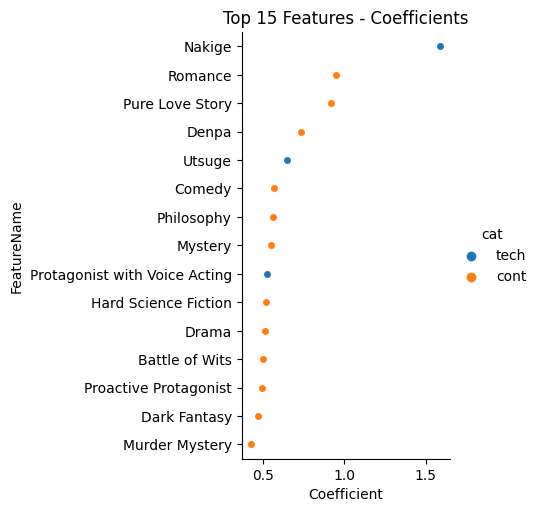

In [ ]:
# Blacklist some terms depending on audience. 
blacklist = []
# Plot the feature coefficients using seaborn
n_features = 15
plt.figure(figsize=(12, 8))
sns.catplot(x='Coefficient', y='FeatureName', hue="cat", data=feature_coef_df[(feature_coef_df["cat"]!="ero")&(~feature_coef_df["FeatureName"].isin(blacklist))].head(n_features))
best_gids = feature_coef_df[(feature_coef_df["cat"]!="ero")&(~feature_coef_df["FeatureName"].isin(blacklist))].head(n_features)["FeatureID"].values
plt.xlabel('Coefficient')
plt.ylabel('FeatureName')
plt.title(f'Top {n_features} Features - Coefficients')
plt.show()

Text(0.5, 1.0, 'Distribution of Nakige votes 2021-present (Hue = Relevancy score)')

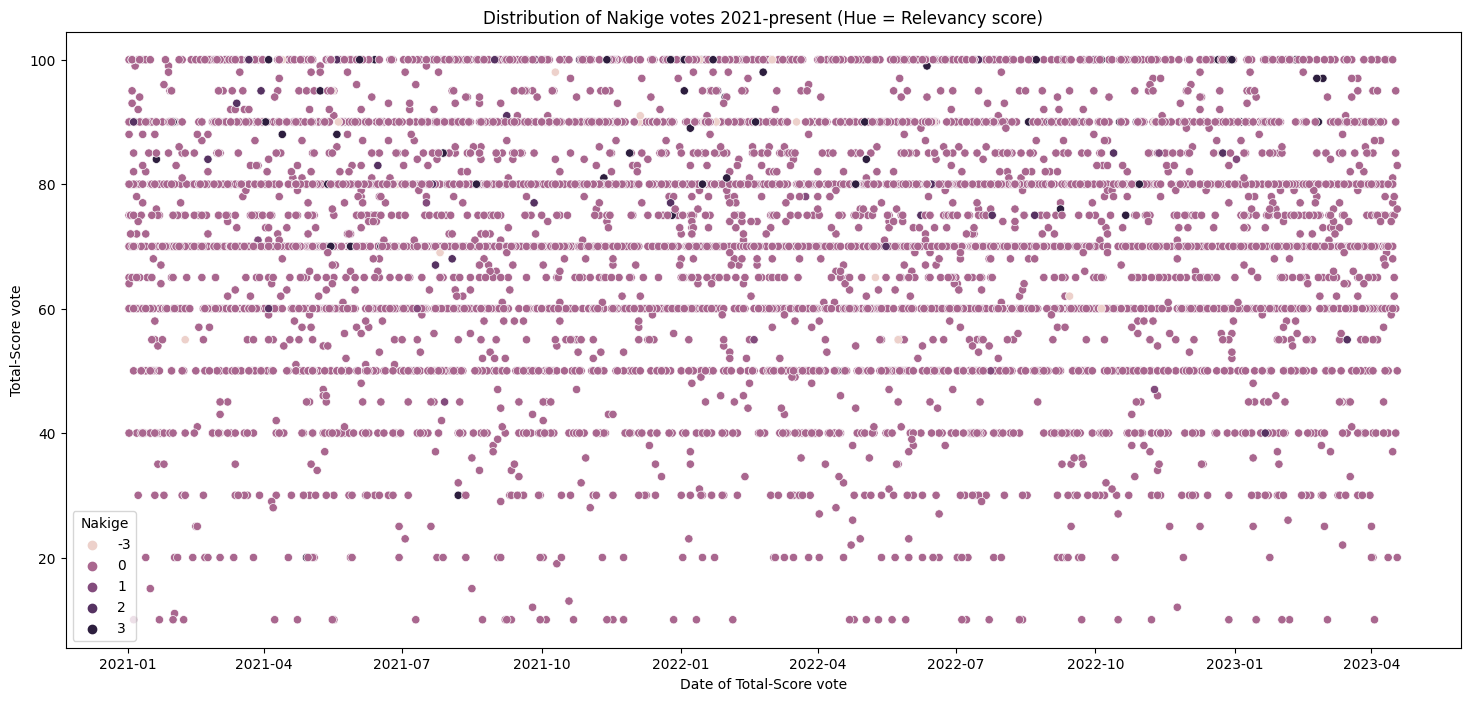

In [ ]:
import datetime
ddf = pd.DataFrame()
ddf['vid_vote_date'] = main_df['vid_vote_date']
ddf['vid_vote'] = main_df['vid_vote']
ddf[tag_name(best_gids[0])] = main_df.loc[:, (['gid_vote'], best_gids[0])]

plt.figure(figsize=(18, 8))
sns.scatterplot(x='vid_vote_date', hue='Nakige', y='vid_vote', data=ddf[ddf['vid_vote_date'].dt.tz_localize(None)
 > datetime.datetime(2021, 1, 1)])
plt.xlabel('Date of Total-Score vote')
plt.ylabel('Total-Score vote')
plt.title(f'Distribution of Nakige votes 2021-present (Hue = Relevancy score)')

In [ ]:
ddf

,vid_vote_date,vid_vote,Nakige
0,2011-06-30 00:00:00+00:00,70.0,0
1,2017-02-12 00:00:00+00:00,94.0,0
2,2019-10-26 00:00:00+00:00,67.0,0
3,2016-01-03 00:00:00+00:00,61.0,0
4,2016-12-03 00:00:00+00:00,69.0,0
...,...,...,...
34325,2019-10-30 00:00:00+00:00,75.0,0
34326,2019-06-23 00:00:00+00:00,70.0,0
34327,2020-12-12 00:00:00+00:00,82.0,0
34328,2019-10-30 00:00:00+00:00,77.0,0


In [ ]:
# Neural Net
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Step 2: Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

# Step 3: Build the neural network model
model = Sequential()
model.add(Dense(128, activation='relu',
                input_shape=(X_train_scaled.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='softmax'))
model.add(Dense(1, activation='linear'))

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mean_squared_error'])
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32)

# Step 5: Evaluate the model
loss, mse = model.evaluate(X_test_scaled, y_test_scaled)
print('Mean Squared Error:', mse)



Epoch 1/50
859/859 [==============================] - 6s 6ms/step - loss: 0.8781 - mean_squared_error: 0.8781
Epoch 2/50
859/859 [==============================] - 6s 7ms/step - loss: 0.7529 - mean_squared_error: 0.7529
Epoch 3/50
859/859 [==============================] - 5s 5ms/step - loss: 0.6772 - mean_squared_error: 0.6772
Epoch 4/50
859/859 [==============================] - 5s 5ms/step - loss: 0.6076 - mean_squared_error: 0.6076
Epoch 5/50
859/859 [==============================] - 6s 7ms/step - loss: 0.5430 - mean_squared_error: 0.5430
Epoch 6/50
859/859 [==============================] - 5s 5ms/step - loss: 0.4877 - mean_squared_error: 0.4877
Epoch 7/50
859/859 [==============================] - 5s 5ms/step - loss: 0.4414 - mean_squared_error: 0.4414
Epoch 8/50
859/859 [==============================] - 7s 8ms/step - loss: 0.4024 - mean_squared_error: 0.4024
Epoch 9/50
859/859 [==============================] - 6s 7ms/step - loss: 0.3676 - mean_squared_error: 0.3676
Epoch 10/5

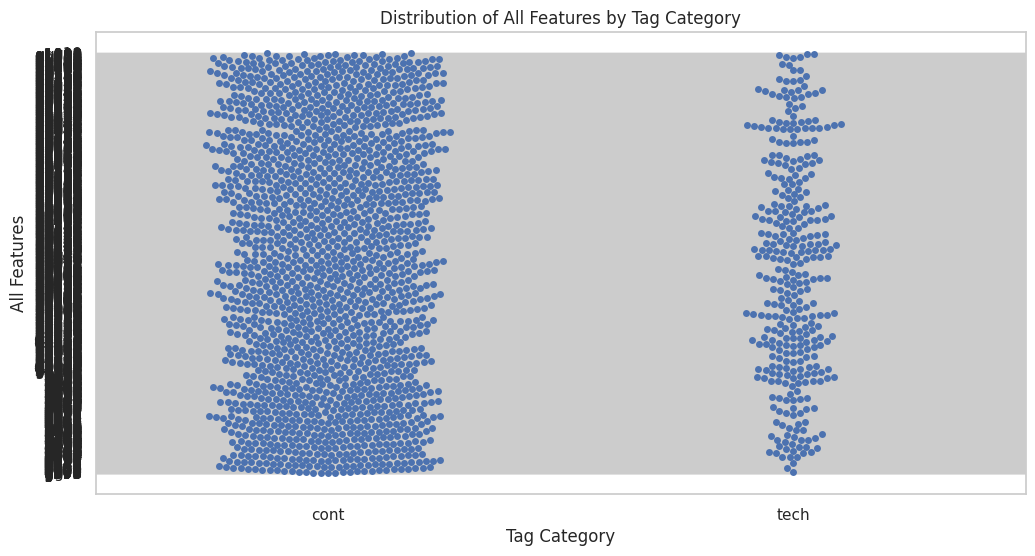

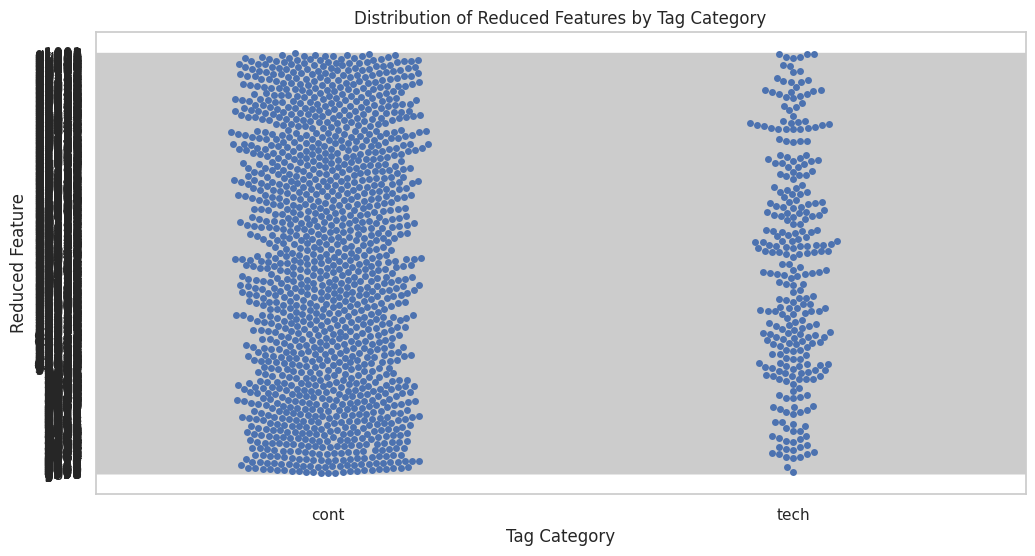

In [ ]:
# PLOT LASSO REDUCTION
import seaborn as sns
import matplotlib.pyplot as plt

# MAP ID <-> CAT
tags_subset = tags_df[["id", "cat"]]
tag_category_dict = dict(zip(tags_subset["id"], tags_subset["cat"]))

all_feature_columns = [item for (_, item) in all_features.tolist()]
reduced_feature_columns = [item for (_, item) in selected_features.tolist()]

all_feature_categories = [tag_category_dict[column] for column in all_feature_columns]
reduced_feature_categories = [tag_category_dict[column] for column in reduced_feature_columns]

all_features_df = pd.DataFrame({"Feature": all_feature_columns, "Category": all_feature_categories})
reduced_features_df = pd.DataFrame({"Feature": reduced_feature_columns, "Category": reduced_feature_categories})

# plot all features
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.swarmplot(x="Category", y="Feature", data=all_features_df[all_features_df["Category"] != "ero"])
plt.xlabel("Tag Category")
plt.ylabel("All Features")
plt.title("Distribution of All Features by Tag Category")
plt.show()

# plot reduced features
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.swarmplot(x="Category", y="Feature", data=reduced_features_df[reduced_features_df["Category"] != "ero"])
plt.xlabel("Tag Category")
plt.ylabel("Reduced Feature")
plt.title("Distribution of Reduced Features by Tag Category")
plt.show()

In [ ]:
# UTILITY/DB EXPLORATION HELPER FUNCTIONS

import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

def tag_name(gid: str):
    names = tags_df[tags_df["id"] == gid]["name"].values
    return names[0] if names.size > 0 else None

def vn_name(vid: str):
    names = vn_titles_df[vn_titles_df["id"] == vid]["title"].values
    return names[0] if names.size > 0 else None

def vn_tags(vid: str, applicable=False, searchable=False):
    search = tags_vn_df[tags_vn_df["vid"]==vid]["tag"]
    return search.drop_duplicates() if not search.empty else None

def tag_score(vid, gid):
    search = tags_vn_df[(tags_vn_df["vid"]==vid)&(tags_vn_df["tag"]==gid)]
    return search["vote"].mean() if not search.empty else None

def ulist_vn_vote_plot(vid: str):
    fig, ax = plt.subplots()
    sns.histplot(
        data=ulist_vns_df[ulist_vns_df["vid"] == vid],
        x="vote_date", y="vote",
        ax=ax, cbar=True
    )
    ax.set_title(vn_name(vid))
    fig.autofmt_xdate()

def votes_over_time():
    fig, ax = plt.subplots()
    sns.histplot(
        data=ulist_vns_df,
        x="vote_date", y="vote",
        ax=ax, cbar=True
    )
    ax.set_title("votes for all series over time")
    fig.autofmt_xdate()

def vn_tag_dist_plot(vid: str, technical=True):
    df = pd.DataFrame()
    df["tags"] = vn_tags(vid)

    if not technical:
        # Filter tags not in tag category "tech"
        df["tags"] = df.loc[~df["tags"].isin(tags_df.loc[tags_df["cat"] == "tech", "id"])]

    df["tag_names"] = df["tags"].apply(lambda x: tag_name(x))
    df["tag_scores"] = df["tags"].apply(lambda x: tag_score(vid, x))
    df.sort_values(by="tag_scores", inplace=True)

    fig, ax = plt.subplots(figsize=(18, 10))
    sns.barplot(data=df, x="tag_names", y="tag_scores", ax=ax)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.title(vn_name(vid))
    return df

def n_most_pop_tags_overtime(vid: str, n=5):
    df = pd.DataFrame()
    df["tags"] = vn_tags(vid)
    df["tag_names"] = df["tags"].apply(lambda x: tag_name(x))
    df["tag_scores"] = df["tags"].apply(lambda x: tag_score(vid, x))
    n_largest = df.nlargest(n, "tag_scores")
    n_largest_tags = n_largest["tags"].values
    df = tags_vn_df[(tags_vn_df["tag"].isin(n_largest["tags"]))&(tags_vn_df["vid"]==vid)]
